In [ ]:
import os
import PIL.Image
import base64
import requests
from io import BytesIO
from typing import Optional, Union

def load_image(image: Union[str, "PIL.Image.Image"], timeout: Optional[float] = None, mode = ["RGB"]) -> "PIL.Image.Image":
    # Inspired by https://github.com/huggingface/transformers/blob/main/src/transformers/image_utils.py
    """
    Loads `image` to a PIL Image.

    Args:
        image (`str` or `PIL.Image.Image`):
            The image to convert to the PIL Image format.
        timeout (`float`, *optional*):
            The timeout value in seconds for the URL request.
        mode ('list'): (added)
            Image representation space ("RGB", "HSV", "LAB"...)

    Returns:
        `np.array`: A PIL Image converted in a np.array.
    """
    if isinstance(image, str):
        if image.startswith("http://") or image.startswith("https://"):
            # We need to actually check for a real protocol, otherwise it's impossible to use a local file
            # like http_huggingface_co.png
            image = PIL.Image.open(BytesIO(requests.get(image, timeout=timeout).content))
        elif os.path.isfile(image):
            image = PIL.Image.open(image)
        else:
            if image.startswith("data:image/"):
                image = image.split(",")[1]

            # Try to load as base64
            try:
                b64 = base64.decodebytes(image.encode())
                image = PIL.Image.open(BytesIO(b64))
            except Exception as e:
                raise ValueError(
                    f"Incorrect image source. Must be a valid URL starting with `http://` or `https://`, a valid path to an image file, or a base64 encoded string. Got {image}. Failed with {e}"
                )
    elif isinstance(image, PIL.Image.Image):
        image = image
    else:
        raise TypeError(
            "Incorrect format used for image. Should be an url linking to an image, a base64 string, a local path, or a PIL image."
        )
    image = PIL.ImageOps.exif_transpose(image)
    if len(mode) == 1:
        image_fin = image.convert(mode[0])
        image_fin = np.array(image_fin)
    else :
        for m in range(len(mode)) :
            if m==0:
                image_fin = image.convert(mode[m])
                image_fin = np.array(image_fin)
            else:
                image_temp = image.convert(mode[m])
                image_temp = np.array(image_temp)
                image_fin = np.append(image_fin, image_temp, axis=2)
    return image_fin


In [ ]:
import numpy as np

def IoU(pred, target,dim_z):
    pred_mask = pred != [0]*dim_z
    target_mask = target != [0]*dim_z

    intersec = np.logical_and(pred_mask, target_mask)
    union = np.logical_or(pred_mask, target_mask)

    score = intersec.sum() / union.sum()

    return round(score, 4)

def specificite(pred, target, dim_z):
    pred_mask = pred == [0]*dim_z
    target_mask = target == [0]*dim_z

    VN = np.logical_and(pred_mask,target_mask)
    FP = np.logical_and(~pred_mask,target_mask)

    score = VN.sum() / (VN.sum() + FP.sum())

    return round(score, 4)

def sensibilite(pred, target, dim_z):
    pred_mask = pred != [0]*dim_z
    target_mask = target != [0]*dim_z

    VP = np.logical_and(pred_mask,target_mask)
    FN = np.logical_and(~pred_mask,target_mask)

    score = VP.sum() / (VP.sum() + FN.sum())

    return round(score, 4)

In [ ]:
# import numpy as np
from sklearn.cluster import KMeans
import copy

def k_means_seg (img, c_num = 4):

    x, y = img.shape[0], img.shape[1]
    if len(img.shape) == 2 :
        z = 1
    else:
        z = img.shape[2]
    img_base = img.reshape(int(img.size / z),z)
    
    clust = KMeans(n_clusters=c_num)
    res = clust.fit(img_base)
    lab = res.labels_.reshape(x, y)
    
    if len(img.shape) < 3 :
        img = np.expand_dims(img, axis=2)
    img_temp = img.tolist()
    for i in range(x):
        for j in range(y):
            img_temp[i][j].append(lab[i,j])

    list_res = {}
    list_res["all"] = np.zeros((x,y,z))

    for c in range(c_num):
        mask = copy.deepcopy(img_temp)
        for i in range(x):
            for j in range(y):
                
                if mask[i][j][len(mask[i][j])-1] == c:
                    mask[i][j][0:len(mask[i][j])-1] = img[i][j][0:len(mask[i][j])-1]
                else:
                    mask[i][j][0:len(mask[i][j])-1] = [0]*(len(mask[i][j])-1)
                
                l = mask[i][j].pop()

        list_res[c] = np.array(mask)
        list_res["all"] += np.array(mask)
    
    return list_res



In [ ]:
# import copy
from tqdm import tqdm
import pandas as pd

def multiple_images(data, mode, iou = False):
    
    data_new = copy.deepcopy(data)
    data_res = pd.DataFrame(np.zeros((data.shape[0], 8)), columns=['feuille', 'inter', 'sup', 'tronc',
                                        'f_clust', 'i_clust', 's_clust', 't_clust'])
    
    for i in tqdm(range(data_new.shape[0])):
        
        if isinstance(mode, str):
            mode = [mode]

        img = load_image(data_new.loc[i, "image"], mode=mode)
        target_mask = load_image(data_new.loc[i, "all"], mode=mode)

        target_leaf = img * ((target_mask == 1) * 1)
        target_interrow = img * ((target_mask == 2) * 1)
        target_sheath = img * ((target_mask == 3) * 1)
        target_trunc = img * ((target_mask == 4) * 1)
        
        clust = k_means_seg(img)
        z = np.array(clust[0]).shape[2]

        list_iou = []
        ind = 0
        col = ['feuille', 'interrow', 'sheath', 'trunc', 'f_clust', 'i_clust', 's_clust', 't_clust']
        for j in [target_leaf, target_sheath, target_interrow, target_trunc]:
            list_iou = []
            for k in range(len(clust)-1):
                list_iou.append(IoU(np.array(clust[k]), j, dim_z=z))
            clust_max = list_iou.index(max(list_iou))
            if iou == False:
                data_res.loc[i,col[ind]] = str(IoU(np.array(clust[clust_max]), j, dim_z=z)) + ' (spe = '+ str(specificite(np.array(clust[clust_max]), j, dim_z=z)) + ', sens = ' + str(sensibilite(np.array(clust[clust_max]), j, dim_z=z)) + ')'
            else :
                data_res.loc[i,col[ind]] = IoU(np.array(clust[clust_max]), j, dim_z=z)
            data_res.loc[i,col[ind + 4]] = clust_max
            ind +=1
    
    data_res["time"] = pd.to_datetime(data_new["day_time"]).dt.strftime("%Y-%m-%d")

    return data_res

In [ ]:
data = pd.read_csv("Image_chara_all.csv")

data

c:\Users\seiko\Stage_fin_annee\test_deep_seg_V2\general.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '75.5625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  img_data.loc[img_data["condition"] == cat, 'dist_sup_tronc'] = cat_dist[cat]


,agroCam,condition,image,feuille,inter,sup,tronc,dist_sup_tronc,day_time
0,4j7g2wk9,DVITI,image/4j7g2wk9_2024-04-19_104603_7_18.jpg,masque_final/4j7g2wk9_2024-04-19_104603_7_18__...,masque_final/4j7g2wk9_2024-04-19_104603_7_18__...,masque_final/4j7g2wk9_2024-04-19_104603_7_18__...,masque_final/4j7g2wk9_2024-04-19_104603_7_18__...,75.5625,2024-04-19 10:46:03
1,4j7g2wk9,DVITI,image/4j7g2wk9_2024-05-01_140147_8_4.jpg,masque_final/4j7g2wk9_2024-05-01_140147_8_4__f...,masque_final/4j7g2wk9_2024-05-01_140147_8_4__i...,masque_final/4j7g2wk9_2024-05-01_140147_8_4__z...,masque_final/4j7g2wk9_2024-05-01_140147_8_4__t...,75.5625,2024-05-01 14:01:47
2,4j7g2wk9,DVITI,image/4j7g2wk9_2024-05-14_140146_8_4.jpg,masque_final/4j7g2wk9_2024-05-14_140146_8_4__f...,masque_final/4j7g2wk9_2024-05-14_140146_8_4__i...,masque_final/4j7g2wk9_2024-05-14_140146_8_4__z...,masque_final/4j7g2wk9_2024-05-14_140146_8_4__t...,75.5625,2024-05-14 14:01:46
3,4j7g2wk9,DVITI,image/4j7g2wk9_2024-05-28_140146_7_92.jpg,masque_final/4j7g2wk9_2024-05-28_140146_7_92__...,masque_final/4j7g2wk9_2024-05-28_140146_7_92__...,masque_final/4j7g2wk9_2024-05-28_140146_7_92__...,masque_final/4j7g2wk9_2024-05-28_140146_7_92__...,75.5625,2024-05-28 14:01:46
4,4j7g2wk9,DVITI,image/4j7g2wk9_2024-06-04_140146_7_92.jpg,masque_final/4j7g2wk9_2024-06-04_140146_7_92__...,masque_final/4j7g2wk9_2024-06-04_140146_7_92__...,masque_final/4j7g2wk9_2024-06-04_140146_7_92__...,masque_final/4j7g2wk9_2024-06-04_140146_7_92__...,75.5625,2024-06-04 14:01:46
5,4j7g2wk9,DVITI,image/4j7g2wk9_2024-06-15_121749_7_98.jpg,masque_final/4j7g2wk9_2024-06-15_121749_7_98__...,masque_final/4j7g2wk9_2024-06-15_121749_7_98__...,masque_final/4j7g2wk9_2024-06-15_121749_7_98__...,masque_final/4j7g2wk9_2024-06-15_121749_7_98__...,75.5625,2024-06-15 12:17:49
6,4j7g2wk9,DVITI,image/4j7g2wk9_2024-06-25_140145_8_4.jpg,masque_final/4j7g2wk9_2024-06-25_140145_8_4__f...,masque_final/4j7g2wk9_2024-06-25_140145_8_4__i...,masque_final/4j7g2wk9_2024-06-25_140145_8_4__z...,masque_final/4j7g2wk9_2024-06-25_140145_8_4__t...,75.5625,2024-06-25 14:01:45
7,4j7g2wk9,DVITI,image/4j7g2wk9_2024-07-05_140146_7_80.jpg,masque_final/4j7g2wk9_2024-07-05_140146_7_80__...,masque_final/4j7g2wk9_2024-07-05_140146_7_80__...,masque_final/4j7g2wk9_2024-07-05_140146_7_80__...,masque_final/4j7g2wk9_2024-07-05_140146_7_80__...,75.5625,2024-07-05 14:01:46
8,4j7g2wk9,DVITI,image/4j7g2wk9_2024-07-13_140147_8_22.jpg,masque_final/4j7g2wk9_2024-07-13_140147_8_22__...,masque_final/4j7g2wk9_2024-07-13_140147_8_22__...,masque_final/4j7g2wk9_2024-07-13_140147_8_22__...,masque_final/4j7g2wk9_2024-07-13_140147_8_22__...,75.5625,2024-07-13 14:01:47
9,4j7g2wk9,DVITI,image/4j7g2wk9_2024-07-25_140146_8_4.jpg,masque_final/4j7g2wk9_2024-07-25_140146_8_4__f...,masque_final/4j7g2wk9_2024-07-25_140146_8_4__i...,masque_final/4j7g2wk9_2024-07-25_140146_8_4__z...,masque_final/4j7g2wk9_2024-07-25_140146_8_4__t...,75.5625,2024-07-25 14:01:46


In [ ]:
rgb = multiple_images(data, iou=True, mode=["RGB"])
lab = multiple_images(data, iou=True, mode=["LAB"])
rgba = multiple_images(data, iou=True, mode=["RGBA"])
hsv = multiple_images(data, iou=True, mode=["HSV"])

rgb_lab = multiple_images(data, iou=True, mode=["RGB", "LAB"])
rgb_hsv = multiple_images(data, iou=True, mode=["RGB", "HSV"])
lab_hsv = multiple_images(data, iou=True, mode=["LAB", "HSV"])

rgb_lab_hsv = multiple_images(data, iou=True, mode=["RGB", "LAB", "HSV"])

100%|██████████| 33/33 [42:17<00:00, 76.91s/it]


In [6]:
rgb["mode"] = "rgb"
lab["mode"] = "lab"
rgba["mode"] = "rgba"
hsv["mode"] = "hsv"

rgb_lab["mode"] = "rgb_lab"
rgb_hsv["mode"] = "rgb_hsv"
lab_hsv["mode"] = "lab_hsv"

rgb_lab_hsv["mode"] = "rgb_lab_hsv"

In [13]:
total_mode = pd.concat([rgb,lab,rgba,hsv,rgb_lab,rgb_hsv,lab_hsv,rgb_lab_hsv])

total_mode["cond"] = [*["DVITI"]*11, *["TVITI"]*11, *["AVITI"]*11]*8

In [ ]:
# Moyenne des IoU sur tout le temps, condition et classe
total_mode_nothing = total_mode.drop(["cond", "time", "f_clust", "i_clust", "s_clust","t_clust"],axis=1, inplace=False)
all_mean = total_mode_nothing.groupby("mode").mean()
print("Moyenne général pour chaque mode de représentation")
print(all_mean.mean(axis=1))

Moyenne général pour chaque mode de représentation
mode
hsv            0.209669
lab            0.207923
lab_hsv        0.207062
rgb            0.148339
rgb_hsv        0.191042
rgb_lab        0.201035
rgb_lab_hsv    0.200502
rgba           0.232724
dtype: float64


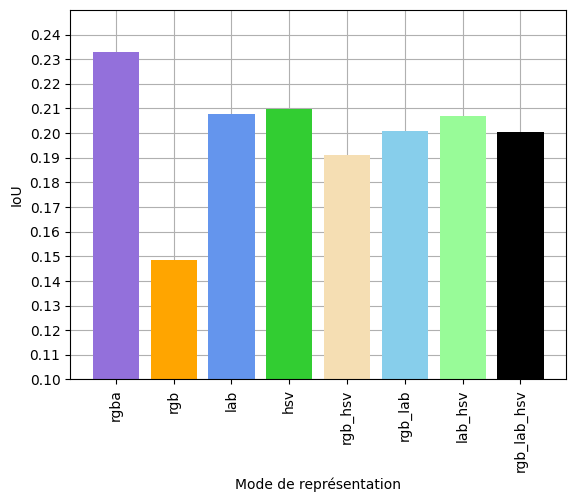

In [ ]:
import matplotlib.pyplot as plt

mode_order = ["rgba", "rgb", "lab", "hsv", "rgb_hsv", "rgb_lab", "lab_hsv", "rgb_lab_hsv"]
color = ['mediumpurple', 'orange', 'cornflowerblue', 'limegreen', 'wheat', "skyblue","palegreen", "black"]

plt.figure()
plt.grid()
plt.rc('axes', axisbelow=True)
plt.bar(all_mean.mean(axis=1).loc[mode_order].index, all_mean.loc[mode_order].mean(axis=1), color = color)
plt.xticks(rotation = 90)
plt.yticks(np.arange(0.10, 0.25, step=0.01))
plt.xlabel("Mode de représentation")
plt.ylabel("IoU")
plt.ylim((0.10,0.25))
plt.show()

In [58]:
all_mean

,feuille,inter,sup,tronc
mode,,,,
hsv,0.456339,0.028536,0.334142,0.019658
lab,0.445836,0.034252,0.328652,0.022952
lab_hsv,0.442997,0.032470,0.331018,0.021764
rgb,0.305633,0.019161,0.259458,0.009106
rgb_hsv,0.418052,0.029000,0.297867,0.019248
rgb_lab,0.427909,0.028133,0.325576,0.022521
rgb_lab_hsv,0.421130,0.038682,0.320503,0.021691
rgba,0.320191,0.175903,0.261700,0.173103


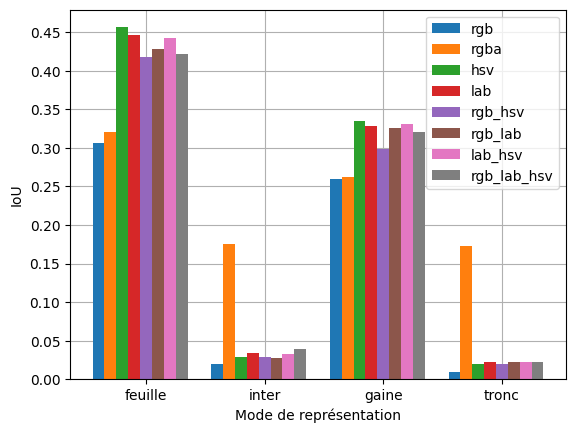

In [118]:
import matplotlib.ticker as ticker

# Décomposition par classe
cats = ["feuille", "inter", "sup", "tronc"] # categories

vals_rgb = [all_mean.loc["rgb", c] for c in cats]
vals_rgba = [all_mean.loc["rgba", c] for c in cats]
vals_hsv = [all_mean.loc["hsv", c] for c in cats]
vals_lab = [all_mean.loc["lab", c] for c in cats]
vals_rgb_hsv = [all_mean.loc["rgb_hsv", c] for c in cats]
vals_rgb_lab = [all_mean.loc["rgb_lab", c] for c in cats]
vals_lab_hsv = [all_mean.loc["lab_hsv", c] for c in cats]
vals_rgb_lab_hsv = [all_mean.loc["rgb_lab_hsv", c] for c in cats]

# Bar width and x locations
w, x = 0.1, np.arange(len(cats))

fig, ax = plt.subplots()
ax.bar(x - 0.4, vals_rgb, width=w, label='rgb')
ax.bar(x - 0.3, vals_rgba, width=w, label='rgba')
ax.bar(x - 0.2, vals_hsv, width=w, label='hsv')
ax.bar(x - 0.1, vals_lab, width=w, label='lab')
ax.bar(x - 0.0, vals_rgb_hsv, width=w, label='rgb_hsv')
ax.bar(x + 0.1, vals_rgb_lab, width=w, label='rgb_lab')
ax.bar(x + 0.2, vals_lab_hsv, width=w, label='lab_hsv')
ax.bar(x + 0.3, vals_rgb_lab_hsv, width=w, label='rgb_lab_hsv')

ax.set_xticks(x)
cats = ["feuille", "inter", "gaine", "tronc"] # categories
ax.set_xticklabels(cats)
ax.set_ylabel('IoU')
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.05))
ax.set_xlabel('Mode de représentation')
ax.grid()
plt.rc('axes', axisbelow=True)
ax.legend()
plt.show()

In [ ]:
# Redondance de cluster choisis
total_mode_clust = total_mode.loc[:,["mode","f_clust", "i_clust", "s_clust","t_clust"]]
total_mode_clust.set_index("mode", inplace=True)

def redond_class(data,cols):
    data = data.loc[:,cols]
    num_class = len(cols)
    mode = np.unique(data.index)
    unic_mode = np.unique(data.index, return_counts = True)
    score = {m : 0 for m in unic_mode[0].tolist()}
    score_num = [i for i in unic_mode[1].tolist()]
    for m in mode:
        score_num_ind = 0
        data_temp = data.loc[m, :]
        for i in range(score_num[score_num_ind]):
            score[m] += len(np.unique(data_temp.iloc[i,:]))
        score[m] = score[m] / score_num[score_num_ind]
        score_num_ind += 1
    return score

redond_res = redond_class(total_mode_clust, ["f_clust", "i_clust", "s_clust","t_clust"])

In [117]:
redond_res

{'hsv': 2.878787878787879,
 'lab': 2.727272727272727,
 'lab_hsv': 2.727272727272727,
 'rgb': 2.4545454545454546,
 'rgb_hsv': 2.909090909090909,
 'rgb_lab': 2.757575757575758,
 'rgb_lab_hsv': 2.787878787878788,
 'rgba': 1.7272727272727273}

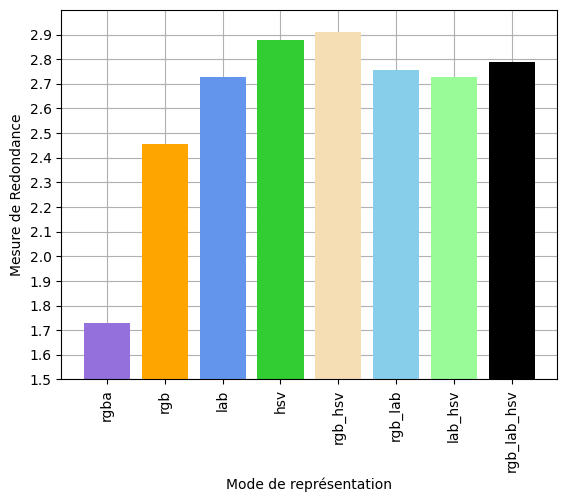

In [113]:
mode_order = ["rgba", "rgb", "lab", "hsv", "rgb_hsv", "rgb_lab", "lab_hsv", "rgb_lab_hsv"]
color = ['mediumpurple', 'orange', 'cornflowerblue', 'limegreen', 'wheat', "skyblue","palegreen", "black"]

reordered_redond_res = {k: redond_res[k] for k in mode_order}

plt.figure()
plt.grid()
plt.rc('axes', axisbelow=True)
plt.bar(reordered_redond_res.keys(), 
        reordered_redond_res.values(), color = color)
plt.xticks(rotation = 90)
plt.yticks(np.arange(1.5, 3.0, step=0.1))
plt.xlabel("Mode de représentation")
plt.ylabel("Mesure de Redondance")
plt.ylim((1.5,3.0))
plt.show()